In [1]:

def create_model():
    inputs = Input((64, 64, 1))
    x = Conv2D(96, (11, 11), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (5, 5), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(384, (3, 3), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    pooledOutput = GlobalAveragePooling2D()(x)
    pooledOutput = Dense(1024)(pooledOutput)
    outputs = Dense(128)(pooledOutput)

    model = Model(inputs, outputs)
    return model

The network takes images of shape 64x64.
Then there are three batches of Conv-Pool-Dropout present in the network .
The network ends with the 128 node Fully Connected Embedding Layer

In [2]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense
from keras.models import Model
feature_extractor = create_model()
imgA = Input(shape=(64, 64, 1))
imgB = Input(shape=(64, 64, 1))
featA = feature_extractor(imgA)
featB = feature_extractor(imgB)

The fact that the network uses the same structure twice with two different images, it actually can be achieved with a single instance of the network. With this the parameter updating also becomes easier, as the weights and the biases will be updated in the same instance only.
Two images are provided to the network, and the network produces the embedding layers or the features, hence the network also acts as a Feature Extractor.

In [3]:
from keras.layers import Lambda
from keras import backend as k
def euclidean_distance(vectors):
    (featA, featB) = vectors
    sum_squared = k.sum(k.square(featA - featB), axis=1, keepdims=True)
    return k.sqrt(k.maximum(sum_squared, k.epsilon()))

distance = Lambda(euclidean_distance)([featA, featB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

The Euclidean distance is calculated by finding out the square root of the sum of the squares of the difference of both the embeddings. Lambda API is used from TensorFlow Layers for this purpose. The distance value is adjusted to a range of 0–1 using Sigmoid.

In [4]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Loss function binary cross entropy is used 

For my Face Recognition system, I’m using the Olivetti dataset fetched from sklearn datasets API. It has a total of 400 face images for 40 people with 10 images per person.

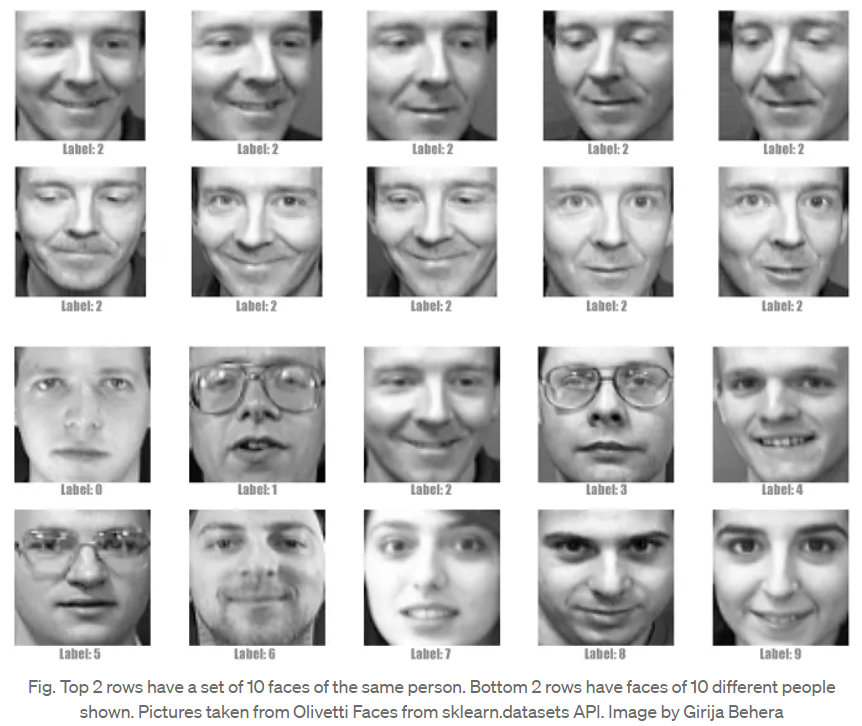

It has ids as the labels for the images. The Olivetti face dataset has the following features.

All the images have only the faces cropped in, even the ears have been cut out.
The images are gray scaled. And it seems the contrast and the brightness are adjusted in them.
A person has around 10 images, each one with possibly a different face expression.

Unlike a Regular CNN, here we don’t generate one image at a time, rather we generate a pair of images from the dataset.



In [5]:
#siamese_train_image_pairs
def generate_train_image_pairs(images_dataset, labels_dataset):
    unique_labels = np.unique(labels_dataset)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels_dataset) if
                                       label == curr_label])
    
    pair_images = []
    pair_labels = []
    for index, image in enumerate(images_dataset):
        pos_indices = label_wise_indices.get(labels_dataset[index])
        pos_image = images_dataset[np.random.choice(pos_indices)]
        pair_images.append((image, pos_image))
        pair_labels.append(1)

        neg_indices = np.where(labels_dataset != labels_dataset[index])
        neg_image = images_dataset[np.random.choice(neg_indices[0])]
        pair_images.append((image, neg_image))
        pair_labels.append(0)
    return np.array(pair_images), np.array(pair_labels)

An image can be paired up with another image of the same label making a positive pair, or with another image of a different label making a negative pair.
The code above starts with collecting the indices for each label.
Then it iterates over the images dataset, and pairs up each image with a random image of the same label as a positive pair, and a random image of any other label as a negative pair.

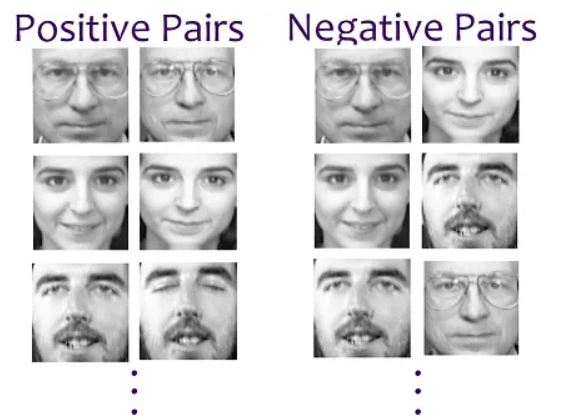

In summary, the function takes two input datasets (images_dataset and labels_dataset) and generates pairs of images along with corresponding labels for training a Siamese network. Positive pairs consist of images with the same label, and negative pairs consist of images with different labels.

This is some sample image pairs generated from the method above. The method generates two image pairs for each image in the dataset. i.e. for each image it generates a positive pair and a negative pair. Hence, a total of 800 image pairs will be generated and used for Model training.

In [13]:
from sklearn.datasets import fetch_olivetti_faces
import numpy as np

# Load the Olivetti faces dataset
data = fetch_olivetti_faces()
images_dataset = data.images
labels_dataset = data.target

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\Hp\scikit_learn_data


In [14]:
#Model training
images_pair, labels_pair = generate_train_image_pairs(images_dataset, labels_dataset)
history = model.fit([images_pair[:, 0], images_pair[:, 1]], labels_pair[:],validation_split=0.1,batch_size=64,epochs=100)


Epoch 1/100
12/12 [==============================] - 29s 2s/step - loss: 0.6539 - accuracy: 0.5000 - val_loss: 0.5692 - val_accuracy: 0.5500
Epoch 2/100
12/12 [==============================] - 26s 2s/step - loss: 0.6587 - accuracy: 0.5000 - val_loss: 0.5799 - val_accuracy: 0.5750
Epoch 3/100
12/12 [==============================] - 25s 2s/step - loss: 0.6246 - accuracy: 0.5000 - val_loss: 0.5817 - val_accuracy: 0.5750
Epoch 4/100
12/12 [==============================] - 25s 2s/step - loss: 0.6190 - accuracy: 0.5097 - val_loss: 0.5808 - val_accuracy: 0.5875
Epoch 5/100
12/12 [==============================] - 25s 2s/step - loss: 0.6139 - accuracy: 0.5292 - val_loss: 0.5810 - val_accuracy: 0.5750
Epoch 6/100
12/12 [==============================] - 24s 2s/step - loss: 0.6560 - accuracy: 0.5542 - val_loss: 0.5724 - val_accuracy: 0.6500
Epoch 7/100
12/12 [==============================] - 24s 2s/step - loss: 0.6185 - accuracy: 0.5264 - val_loss: 0.6106 - val_accuracy: 0.6000
Epoch 8/100
1

Epoch 59/100
12/12 [==============================] - 23s 2s/step - loss: 0.4892 - accuracy: 0.7972 - val_loss: 0.5434 - val_accuracy: 0.7500
Epoch 60/100
12/12 [==============================] - 25s 2s/step - loss: 0.4823 - accuracy: 0.8069 - val_loss: 0.5273 - val_accuracy: 0.7750
Epoch 61/100
12/12 [==============================] - 25s 2s/step - loss: 0.4849 - accuracy: 0.8056 - val_loss: 0.5596 - val_accuracy: 0.7375
Epoch 62/100
12/12 [==============================] - 25s 2s/step - loss: 0.4818 - accuracy: 0.8042 - val_loss: 0.5298 - val_accuracy: 0.7375
Epoch 63/100
12/12 [==============================] - 25s 2s/step - loss: 0.4796 - accuracy: 0.7972 - val_loss: 0.5448 - val_accuracy: 0.7875
Epoch 64/100
12/12 [==============================] - 25s 2s/step - loss: 0.4803 - accuracy: 0.8000 - val_loss: 0.5597 - val_accuracy: 0.7000
Epoch 65/100
12/12 [==============================] - 25s 2s/step - loss: 0.4801 - accuracy: 0.8278 - val_loss: 0.5320 - val_accuracy: 0.7375
Epoch 

Each time we provide 64 pairs of images in a batch and this runs for 100 iterations.

The validation loss decreases constantly up to 80 iterations, then it does not change much. Similarly, no noticeable increment in the validation accuracy after the first few iterations. 

The test image will be paired up with one random image for each person in the dataset.
To do this, I find all the indices for each of the labels again. (like earlier during training image pair generation).
Then for each label a random image is fetched and paired up with the test image.
The whole test image pairs now consist of a total of 40 image pairs, as the dataset has 400 images for 40 people.

In [17]:
#siamese_test
def generate_test_image_pairs(images_dataset, labels_dataset, image):
    unique_labels = np.unique(labels_dataset)
    label_wise_indices = dict()
    for label in unique_labels:
          label_wise_indices.setdefault(label,
                                        [index for index, curr_label in enumerate(labels_dataset) if
                                         label == curr_label])
  
    pair_images = []
    pair_labels = []
    for label, indices_for_label in label_wise_indices.items():
        test_image = images_dataset[np.random.choice(indices_for_label)]
        pair_images.append((image, test_image))
        pair_labels.append(label)
    return np.array(pair_images), np.array(pair_labels)

1/1 [==============================] - 0s 41ms/step


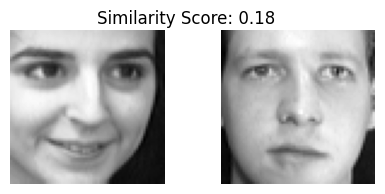

1/1 [==============================] - 0s 27ms/step


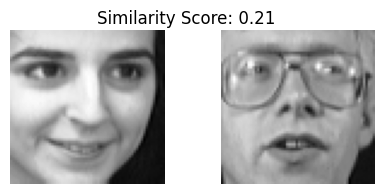

1/1 [==============================] - 0s 37ms/step


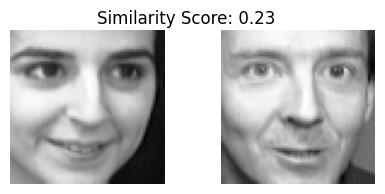

1/1 [==============================] - 0s 33ms/step


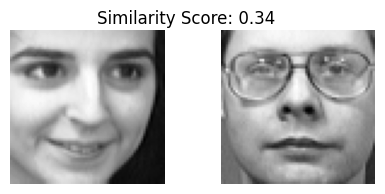

1/1 [==============================] - 0s 31ms/step


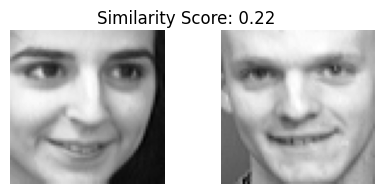

1/1 [==============================] - 0s 30ms/step


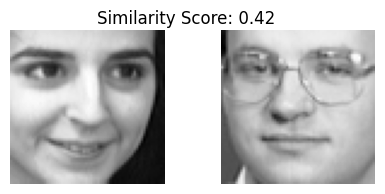

1/1 [==============================] - 0s 33ms/step


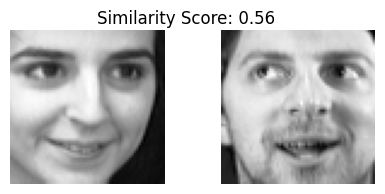

1/1 [==============================] - 0s 33ms/step


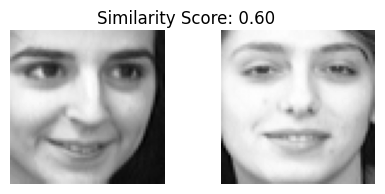

1/1 [==============================] - 0s 35ms/step


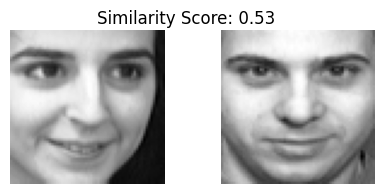

1/1 [==============================] - 0s 29ms/step


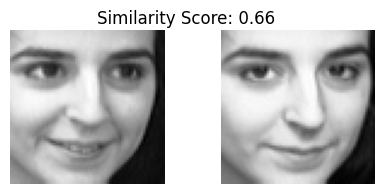

1/1 [==============================] - 0s 30ms/step


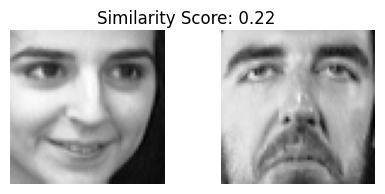

1/1 [==============================] - 0s 32ms/step


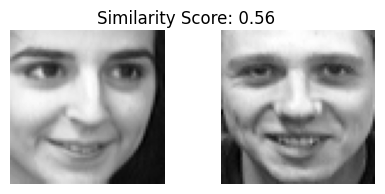

1/1 [==============================] - 0s 31ms/step


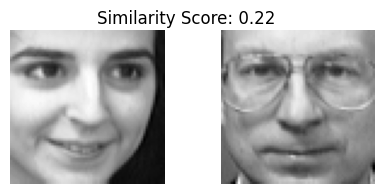

1/1 [==============================] - 0s 31ms/step


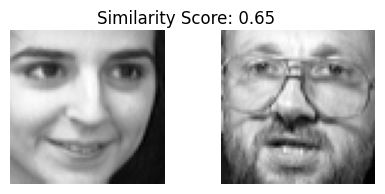

1/1 [==============================] - 0s 36ms/step


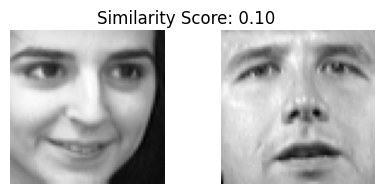

1/1 [==============================] - 0s 30ms/step


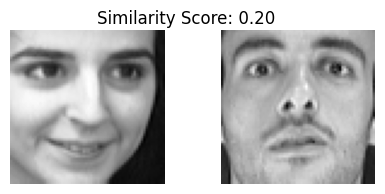

1/1 [==============================] - 0s 30ms/step


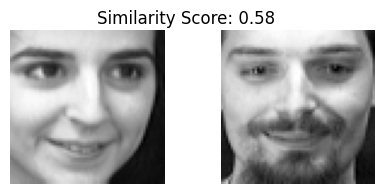

1/1 [==============================] - 0s 28ms/step


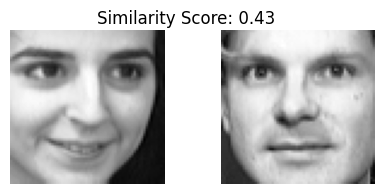

1/1 [==============================] - 0s 28ms/step


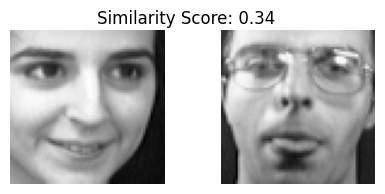

1/1 [==============================] - 0s 28ms/step


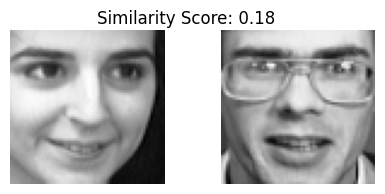

1/1 [==============================] - 0s 27ms/step


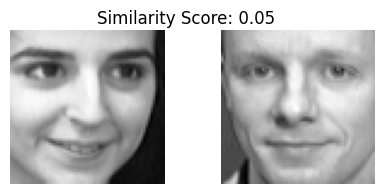

1/1 [==============================] - 0s 30ms/step


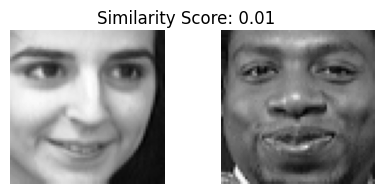

1/1 [==============================] - 0s 26ms/step


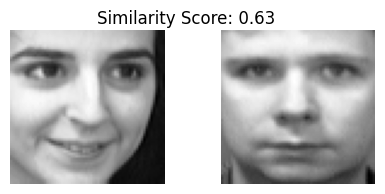

1/1 [==============================] - 0s 28ms/step


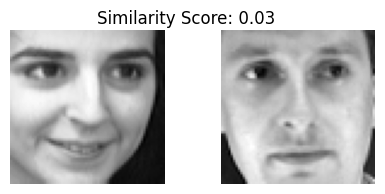

1/1 [==============================] - 0s 29ms/step


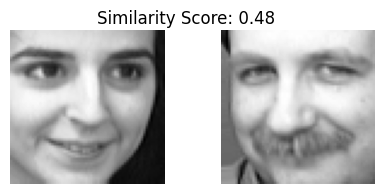

1/1 [==============================] - 0s 31ms/step


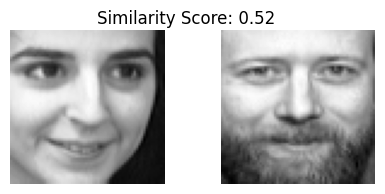

1/1 [==============================] - 0s 33ms/step


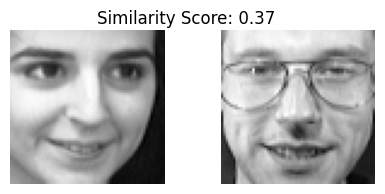

1/1 [==============================] - 0s 32ms/step


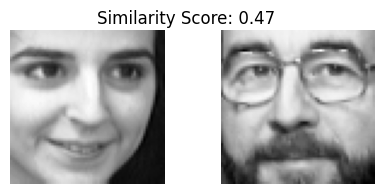

1/1 [==============================] - 0s 33ms/step


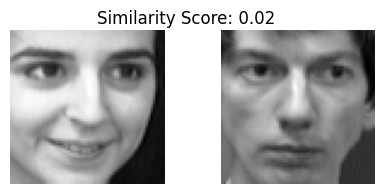

1/1 [==============================] - 0s 30ms/step


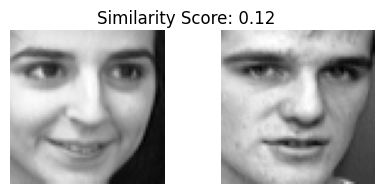

1/1 [==============================] - 0s 28ms/step


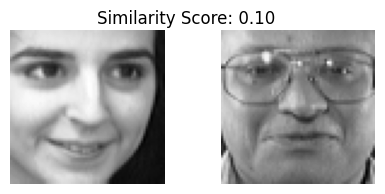

1/1 [==============================] - 0s 31ms/step


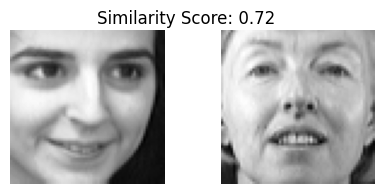

1/1 [==============================] - 0s 32ms/step


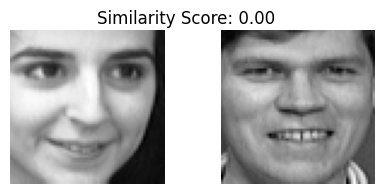

1/1 [==============================] - 0s 32ms/step


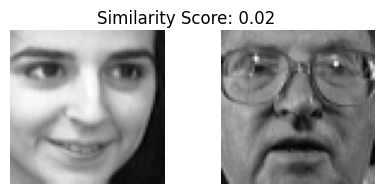

1/1 [==============================] - 0s 32ms/step


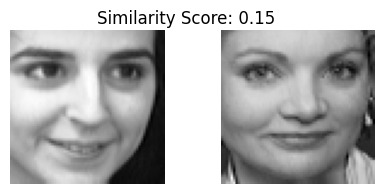

1/1 [==============================] - 0s 32ms/step


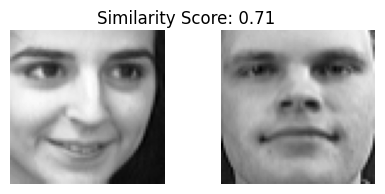

1/1 [==============================] - 0s 31ms/step


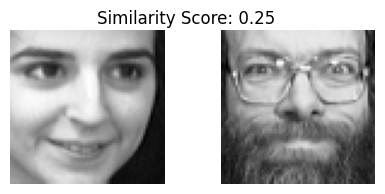

1/1 [==============================] - 0s 29ms/step


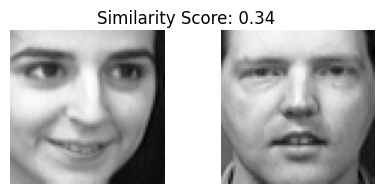

1/1 [==============================] - 0s 28ms/step


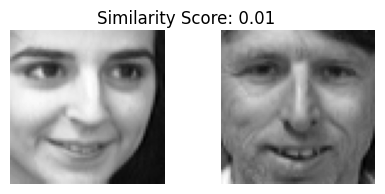

1/1 [==============================] - 0s 28ms/step


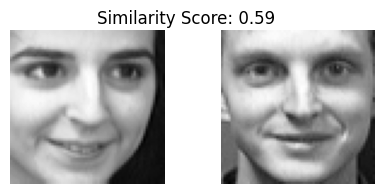

In [20]:
image = images_dataset[92]  # a random image as a test image
test_image_pairs, test_label_pairs = generate_test_image_pairs(images_dataset, labels_dataset, image)

# for each pair in the test image pair, predict the similarity between the images
import matplotlib.pyplot as plt

def show_images_and_prediction(pair, prediction):
    plt.figure(figsize=(5, 2))

    # Display first image
    plt.subplot(1, 2, 1)
    plt.imshow(pair[0].reshape(64, 64), cmap='gray')
    plt.axis('off')

    # Display second image
    plt.subplot(1, 2, 2)
    plt.imshow(pair[1].reshape(64, 64), cmap='gray')
    plt.axis('off')

    # Print prediction
    plt.suptitle(f"Similarity Score: {prediction:.2f}")
    plt.show()

for index, pair in enumerate(test_image_pairs):
    pair_image1 = np.expand_dims(pair[0], axis=-1)
    pair_image1 = np.expand_dims(pair_image1, axis=0)
    pair_image2 = np.expand_dims(pair[1], axis=-1)
    pair_image2 = np.expand_dims(pair_image2, axis=0)
    prediction = model.predict([pair_image1, pair_image2])[0][0]

    show_images_and_prediction(pair, prediction)



From above results we can observe that if similarity is >0.65 then both the images are likely of same person. So we can write the code as follows with threshold.

1/1 [==============================] - 0s 29ms/step


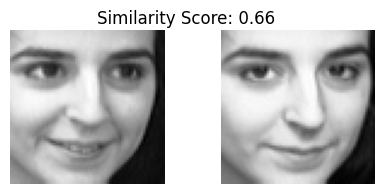

1/1 [==============================] - 0s 33ms/step


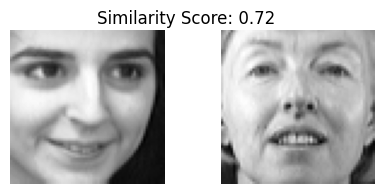

1/1 [==============================] - 0s 31ms/step


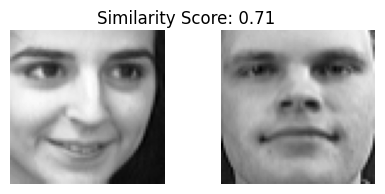

1/1 [==============================] - 0s 33ms/step


In [24]:
#It will show only those pairs in which both the images are of same person
# Define a threshold for similarity
similarity_threshold = 0.655
for index, pair in enumerate(test_image_pairs):
    pair_image1 = np.expand_dims(pair[0], axis=-1)
    pair_image1 = np.expand_dims(pair_image1, axis=0)
    pair_image2 = np.expand_dims(pair[1], axis=-1)
    pair_image2 = np.expand_dims(pair_image2, axis=0)
    prediction = model.predict([pair_image1, pair_image2])[0][0]

    if prediction > similarity_threshold:
        show_images_and_prediction(pair, prediction)

Here we can observe that model is giving some extra pairs also. So it's not very good. Following are some of the changes that can be tried to improve the model. But it takes a lot of time for training and due to time constraint I can't try those changes now. But I will try them in future.

# Model Improvement Strategies

1. **Adjust Convolutional Layers:**
   - Experiment with different sizes and numbers of filters in your Conv2D layers.
   - Consider smaller filters (e.g., 3x3 or 5x5) to capture finer details.

2. **Add More Convolutional Layers:**
   - Deeper networks can capture more complex patterns.
   - Be cautious of overfitting when adding more layers.

3. **Batch Normalization:**
   - Include BatchNormalization layers to normalize activations and prevent internal covariate shift.

4. **Experiment with Dropout Rates:**
   - Adjust dropout rates to reduce overfitting.
   - Experiment with different rates to find the optimal value.

5. **Use More Advanced Layers:**
   - Consider layers like Residual Connections, Depthwise Separable Convolutions, or Attention Mechanisms.

6. **Fine-tune Dense Layers:**
   - Adjust the number of neurons in Dense layers for improved model performance.

7. **Learning Rate Scheduling:**
   - Implement learning rate scheduling or use adaptive optimizers (e.g., Adam, RMSprop) for efficient convergence.

8. **Data Augmentation:**
   - Increase dataset size with modified versions of input images (flipped, rotated, scaled, etc.).

9. **Regularization Techniques:**
   - Use L1 or L2 regularization in layers to prevent overfitting.

10. **Hyperparameter Optimization:**
    - Use grid search or random search to experiment with different hyperparameter sets.

11. **Evaluate Different Activation Functions:**
    - Experiment with activations like LeakyReLU or ELU, in addition to the common ReLU.

12. **Increase Model Complexity Carefully:**
    - If the model is too simple, cautiously increase complexity to capture underlying patterns without overfitting.

13. **Use Pretrained Models:**
    - Consider transfer learning by starting with a model pretrained on a large dataset and fine-tuning for your specific task.


Siamese model is mostly used when we don’t have a huge number of images for the training. A Deep Learning Neural Network for Classification performs better only when the number of images in the dataset is huge.

For ex. If we are building a Face Recognition System for an Office with only 100 employees. Their face repository has only a maximum of 10 face images for each of them. Here the number of images are really less, to create a Classification Neural Network. Siamese Network comes in as a handy replacement here. It does not learn the classes, rather it only finds the distance between the images. The number of images need not be high for a Siamese Network.

# Main benefit of Siamese Network 

When we want to add new image to the dataset then a Regular CNN would need a new model to be retrained with the new image data for classification. But for <b>Siamese Network, we don’t need to retrain the model</b>. It would be able to find the distance out between two unseen images as well. So if we want to add an image of a new person then we don't need to retrain the model. WE can simply add it in the dataset and the model can give us the predictions i.e. its similarity with other images.